In [1]:
import json
import yaml
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings('ignore', category=UserWarning)

### **Extract Data**

In [2]:
# Through online GitHub
file_name = 'https://github.com/ourownstory/neuralprophet-data/raw/main/datasets/air_passengers.csv'

In [3]:
dataset = pd.read_csv(file_name)

In [4]:
dataset.shape

(144, 2)

In [5]:
dataset.columns

Index(['ds', 'y'], dtype='object')

In [6]:
dataset.dtypes

ds    object
y      int64
dtype: object

In [7]:
dataset.head()

,ds,y
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [8]:
time_col = dataset.columns[0]
target_col = dataset.columns[-1]
dataset[time_col] = pd.to_datetime(dataset[time_col])
dataset.set_index(time_col, inplace=True)
dataset.index = dataset.index + pd.offsets.MonthEnd(0)
dataset = dataset.asfreq('M')

In [9]:
target_col

'y'

In [10]:
dataset

,y
ds,
1949-01-31,112
1949-02-28,118
1949-03-31,132
1949-04-30,129
1949-05-31,121
...,...
1960-08-31,606
1960-09-30,508
1960-10-31,461


<Axes: xlabel='ds'>

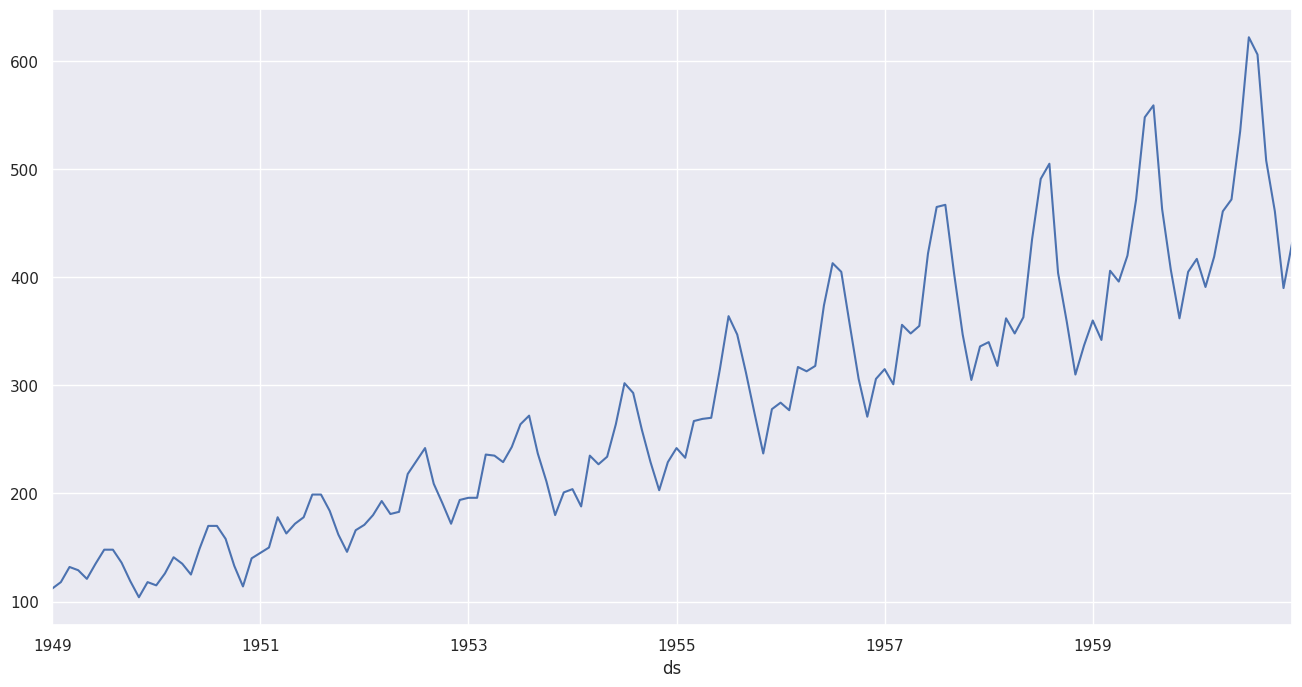

In [11]:
figsize = (16, 8)
dataset[target_col].plot(figsize=figsize)

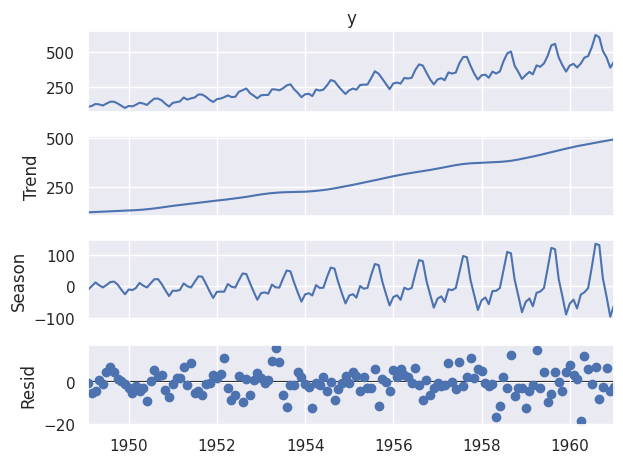

In [12]:
from statsmodels.tsa.seasonal import STL

stl = STL(dataset[target_col], period=12, seasonal=13)
res = stl.fit()
fig = res.plot()

In [13]:
from statsmodels.tsa.stattools import adfuller

#perform augmented Dickey-Fuller test
adfuller(res.resid)

(-5.098010977108992,
 1.4148675043445649e-05,
 9,
 134,
 {'1%': -3.480118600110386,
  '5%': -2.8833618426136196,
  '10%': -2.578407034974382},
 822.6458135470642)

In [14]:
dataset[target_col] = res.resid
seasonality = res.seasonal
trend = res.trend

In [15]:
train_size = 0.8
train_points = int(train_size*len(dataset))
train_df = dataset.iloc[:train_points]
test_df = dataset.iloc[train_points:]

In [16]:
train_points = int(train_size*len(train_df)) #further split train dataset to train and calibration
cal_df = train_df.iloc[train_points:]
train_df = train_df.iloc[:train_points]

In [17]:
df_dict = {'train': train_df, 'calibration': cal_df, 'test': test_df}
for key, value in df_dict.items():
    print(f'{key} dataframe shape: {value.shape}')

train dataframe shape: (92, 1)
calibration dataframe shape: (23, 1)
test dataframe shape: (29, 1)


### **Base model fitting (prior to fit mauq)**

This section is explaining how MAUQ service works under-the-hood. Steps:
1. Split data into into train, calibration, and test datasets
2. Use model to fit on train dataset 
3. Use fitted model to predict the calibration dataset
4. Get the nonconformity score, or the absolute residual, from the calibration dataset
5. Get the q_hat value, at the given confidence level, of the nonconfirmity scores
6. Use q_hat value to create the lower and upper intervals of y_pred, at the given confidence level

See the **MAUQ Quantify Uncertainty API** for the example to running the MAUQ service.

**Step 1) Split air passenger data into train, calibration, and test datasets**

In [18]:
y_train = train_df[target_col]
y_cal = cal_df[target_col]
y_test = test_df[target_col]

**Step 2) Use AutoARIMA model to fit on train dataset**

In [19]:
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.base import ForecastingHorizon
from sktime.utils.plotting import plot_series

In [20]:
fh_cal = ForecastingHorizon(pd.date_range(start=y_train.index[-1], periods=len(y_cal)+1, freq='M')[1:], is_relative=False)
fh_test = ForecastingHorizon(pd.date_range(start=y_cal.index[-1], periods=len(y_test)+1, freq='M')[1:], is_relative=False)
forecaster = AutoARIMA(seasonal=False, stationary=True)
forecaster.fit(y_train)

AutoARIMA(seasonal=False, stationary=True)

**Step 3) Use fitted AutoARIMA model to predict the calibration dataset**

In [21]:
y_pred_cal = forecaster.predict(fh_cal)
y_pred_test = forecaster.predict(fh_test)

In [22]:
# data input calibration set
cal_trend = trend.loc[cal_df.index]
cal_seasonal = seasonality.loc[cal_df.index]
cal_df[target_col] += cal_trend + cal_seasonal
input_data_cal = cal_df.copy()
input_data_cal['y_pred'] = y_pred_cal + cal_trend + cal_seasonal
input_data_cal

,y,y_pred
ds,,
1956-09-30,355.0,351.903969
1956-10-31,306.0,311.873622
1956-11-30,271.0,273.607613
1956-12-31,306.0,306.189725
1957-01-31,315.0,317.026721
1957-02-28,301.0,302.542218
1957-03-31,356.0,346.996170
1957-04-30,348.0,347.924560
1957-05-31,355.0,358.216534


In [23]:
# data input test set (optional)
test_trend = trend.loc[test_df.index]
test_seasonal = seasonality.loc[test_df.index]
test_df[target_col] += test_trend + test_seasonal
input_data_test = test_df.copy()
input_data_test['y_pred'] = y_pred_test + test_trend + test_seasonal
input_data_test

/tmp/ipykernel_2077019/3867515177.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df[target_col] += test_trend + test_seasonal


,y,y_pred
ds,,
1958-08-31,505.0,491.863957
1958-09-30,404.0,410.569162
1958-10-31,359.0,361.584717
1958-11-30,310.0,312.611600
1958-12-31,337.0,349.601888
1959-01-31,360.0,364.237937
1959-02-28,342.0,343.238255
1959-03-31,406.0,390.740917
1959-04-30,396.0,398.955284


In [24]:
# data input train set (optional)
train_trend = trend.loc[train_df.index]
train_seasonal = seasonality.loc[train_df.index]
train_df[target_col] += train_trend + train_seasonal
input_data_train = train_df.copy()
input_data_train

,y
ds,
1949-01-31,112.0
1949-02-28,118.0
1949-03-31,132.0
1949-04-30,129.0
1949-05-31,121.0
...,...
1956-04-30,313.0
1956-05-31,318.0
1956-06-30,374.0


**Step 4) Get the *nonconformity* score, which is the residual, or y - y_pred of the calibration set. Not *absolute* unlike the interval output.**

Get the *nonconformity* score, which is the residual, or y - y_pred of the calibration set. Not *absolute* unlike the interval output.

In [25]:
# Nonconformity score
nc_scores = input_data_cal['y_pred'] - input_data_cal['y'] #nonconformity scores on the calibration/validation set
nc_scores

ds
1956-09-30    -3.096031
1956-10-31     5.873622
1956-11-30     2.607613
1956-12-31     0.189725
1957-01-31     2.026721
1957-02-28     1.542218
1957-03-31    -9.003830
1957-04-30    -0.075440
1957-05-31     3.216534
1957-06-30    -9.683002
1957-07-31     1.713438
1957-08-31    -2.351181
1957-09-30   -11.289764
1957-10-31    -1.802776
1957-11-30    -6.213675
1957-12-31    -5.208100
1958-01-31     0.663339
1958-02-28     2.006754
1958-03-31     1.054888
1958-04-30    16.559881
1958-05-31    11.643546
1958-06-30    -2.615755
1958-07-31     2.834887
Freq: M, dtype: float64

Sort the residuals

In [26]:
nc_scores_sorted = nc_scores.sort_values().values #sorted residuals
nc_scores_sorted

array([-11.28976374,  -9.68300156,  -9.00383014,  -6.21367523,
        -5.20809994,  -3.09603057,  -2.61575463,  -2.35118119,
        -1.80277622,  -0.07543968,   0.18972496,   0.6633393 ,
         1.0548877 ,   1.54221761,   1.71343761,   2.00675447,
         2.02672051,   2.60761256,   2.83488668,   3.21653441,
         5.87362203,  11.64354556,  16.5598808 ])

In [27]:
# number of calibration set
len(nc_scores_sorted)

23

Calculate the distribution by adding the sorted calibration residuals to each y_pred in the test set.

In [28]:
cpds = np.array([input_data_test['y_pred'][i] + nc_scores_sorted for i in range(len(input_data_test['y_pred']))]) 
cpds

array([[480.57419345, 482.18095563, 482.86012705, 485.65028196,
        486.65585725, 488.76792662, 489.24820256, 489.512776  ,
        490.06118097, 491.78851751, 492.05368215, 492.52729648,
        492.91884489, 493.4061748 , 493.5773948 , 493.87071165,
        493.8906777 , 494.47156975, 494.69884387, 495.0804916 ,
        497.73757922, 503.50750275, 508.42383799],
       [399.27939778, 400.88615995, 401.56533137, 404.35548628,
        405.36106157, 407.47313094, 407.95340688, 408.21798032,
        408.76638529, 410.49372184, 410.75888647, 411.23250081,
        411.62404921, 412.11137912, 412.28259912, 412.57591598,
        412.59588203, 413.17677407, 413.4040482 , 413.78569593,
        416.44278354, 422.21270708, 427.12904231],
       [350.29495373, 351.9017159 , 352.58088733, 355.37104224,
        356.37661753, 358.48868689, 358.96896284, 359.23353628,
        359.78194125, 361.50927779, 361.77444242, 362.24805676,
        362.63960517, 363.12693507, 363.29815507, 363.59147193,
  

In [29]:
# The number of distribution points is equal number calibration set data points.
# That is why the dim of the test set CPD is (len test set, len cal set).
cpds.shape

(29, 23)

Alternatively, you can get the distribution by using the ConformalPredictiveSystem by the crepe library. Fit on the nonconformity scores then predict with the distribution on the test set.

In [30]:
# from crepes import ConformalPredictiveSystem
# cps_norm = ConformalPredictiveSystem().fit(nc_scores) #using the nonconformity scores (residual) to fit crepes CPS

In [31]:
# cpds = cps_norm.predict(input_data_test['y_pred'], #Calculate the distribution
#                 return_cpds=True
#                 )
# cpds

Compute what is the quantile percentile for each distribution point based on the number of desired bins, as well as the confidence level. The quantiles are uniformly split. The max possible number of bins will be the number of calibration set data points, as the distribution points is no more granular than that.

In [32]:
def compute_percentiles(data, num_bins=None, confidence_level=None):
    """
    Compute percentile values for a given distribution.
    
    Parameters:
        data (array-like): The input distribution.
        num_bins (int, optional): Number of bins to split the distribution into.
    
    Returns:
        np.ndarray: Array of computed percentile values.
    """
    if confidence_level:
        lower = 100*(1-confidence_level)/2
        upper = 100*confidence_level+lower
        if num_bins:
            percentiles = np.linspace(lower, upper, num_bins + 1)
        else:
            percentiles = np.linspace(lower, upper, 11)  # Default to deciles         
    else:
        if num_bins:
            percentiles = np.linspace(0, 100, num_bins + 1)
        else:
            percentiles = np.linspace(0, 100, 11)  # Default to deciles

    percentile_cols = [str(x) + ' percentile' for x in percentiles]
    output = [np.percentile(x, percentiles) for x in data]
    
    return percentile_cols, output

Ouput the results with the y, y_pred, and the quantiles that were produced by the CPD.

In [33]:
# from src.models.utils import compute_percentiles
confidence_level = 0.9  # 1-alpha
num_bins = 10  # number of bins to calculate percentiles from distribution
p_cols, p = compute_percentiles(cpds, confidence_level=confidence_level, num_bins=num_bins)
test_uq = pd.concat([input_data_test, pd.DataFrame(data=p, columns=p_cols, index=input_data_test.index)], axis=1)
test_uq

,y,y_pred,4.999999999999999 percentile,14.0 percentile,23.0 percentile,32.0 percentile,41.0 percentile,50.0 percentile,59.0 percentile,68.0 percentile,77.0 percentile,86.0 percentile,95.0 percentile
ds,,,,,,,,,,,,,
1958-08-31,505.0,491.863957,482.248873,485.730728,488.796743,489.534712,491.793821,492.527296,493.396428,493.858979,494.436716,495.049960,502.930510
1958-09-30,404.0,410.569162,400.954077,404.435932,407.501947,408.239917,410.499025,411.232501,412.101633,412.564183,413.141921,413.755164,421.635715
1958-10-31,359.0,361.584717,351.969633,355.451488,358.517503,359.255472,361.514581,362.248057,363.117188,363.579739,364.157477,364.770720,372.651271
1958-11-30,310.0,312.611600,302.996515,306.478371,309.544386,310.282355,312.541464,313.274939,314.144071,314.606622,315.184359,315.797603,323.678153
1958-12-31,337.0,349.601888,339.986804,343.468659,346.534674,347.272643,349.531752,350.265228,351.134359,351.596910,352.174648,352.787891,360.668442
1959-01-31,360.0,364.237937,354.622852,358.104708,361.170723,361.908692,364.167800,364.901276,365.770408,366.232959,366.810696,367.423939,375.304490
1959-02-28,342.0,343.238255,333.623171,337.105026,340.171041,340.909010,343.168119,343.901595,344.770726,345.233277,345.811014,346.424258,354.304808
1959-03-31,406.0,390.740917,381.125832,384.607687,387.673703,388.411672,390.670780,391.404256,392.273388,392.735938,393.313676,393.926919,401.807470
1959-04-30,396.0,398.955284,389.340200,392.822055,395.888070,396.626039,398.885148,399.618624,400.487755,400.950306,401.528043,402.141287,410.021837


### **MAUQ Quantify Uncertainty API**

In [34]:
with open('url.yaml', 'r') as file:
    url_dict = yaml.safe_load(file)

In [35]:
api_json = {
    'data': input_data_cal.values.tolist(),
    'train': None,
    'test': input_data_test.values.tolist(),
    'problem_type': 'regression',
    'proba_type': 'distribution',
    'confidence_level': 0.9,
    'num_bins': 10,
    'output_type': 'data'
}

In [36]:
# URL to our MAUQ AWS service
protocol = url_dict['protocol']  # protocol not sybil_protocol
host = url_dict['host']
port = url_dict['port']
endpoint = 'quantify-uncertainty'

url = '%s://%s:%s/%s' % (protocol, host, str(port), endpoint)

In [37]:
%%time
response = requests.post(url, json=api_json)
print(response)
print()

<Response [200]>

CPU times: user 62.8 ms, sys: 0 ns, total: 62.8 ms
Wall time: 235 ms


In [38]:
uncertainty_json_out = response.json()
# uncertainty_json_out

In [39]:
import numpy as np
def get_quantile_column_header(confidence_level, num_bins):
    error_rate = round((1 - confidence_level)*100, 2)
    lower_quantile, upper_quantile = error_rate/2, 100 - error_rate/2
    quantiles = np.linspace(lower_quantile, upper_quantile, num=num_bins+1)
    quantile_cols = [f'{quantile}% quantile' for quantile in quantiles]
    return quantile_cols

In [40]:
quantile_cols = get_quantile_column_header(api_json['confidence_level'], api_json['num_bins'])
uncertainty_cols = list(input_data_test.columns) + quantile_cols
uncertainty_df = pd.DataFrame(uncertainty_json_out['output'], columns=uncertainty_cols).set_index(input_data_test.index)

In [41]:
uncertainty_df

,y,y_pred,5.0% quantile,14.0% quantile,23.0% quantile,32.0% quantile,41.0% quantile,50.0% quantile,59.0% quantile,68.0% quantile,77.0% quantile,86.0% quantile,95.0% quantile
ds,,,,,,,,,,,,,
1958-08-31,505.0,491.863957,480.797404,488.677955,489.291198,489.868935,490.331486,491.200618,491.934094,494.193202,494.931171,497.997186,501.479042
1958-09-30,404.0,410.569162,399.502608,407.383159,407.996402,408.574140,409.036691,409.905822,410.639298,412.898407,413.636376,416.702391,420.184246
1958-10-31,359.0,361.584717,350.518164,358.398715,359.011958,359.589696,360.052246,360.921378,361.654854,363.913962,364.651931,367.717947,371.199802
1958-11-30,310.0,312.611600,301.545047,309.425597,310.038841,310.616578,311.079129,311.948261,312.681736,314.940845,315.678814,318.744829,322.226684
1958-12-31,337.0,349.601888,338.535335,346.415886,347.029129,347.606867,348.069417,348.938549,349.672025,351.931133,352.669102,355.735118,359.216973
1959-01-31,360.0,364.237937,353.171384,361.051934,361.665178,362.242915,362.705466,363.574598,364.308073,366.567182,367.305151,370.371166,373.853021
1959-02-28,342.0,343.238255,332.171702,340.052253,340.665496,341.243233,341.705784,342.574916,343.308392,345.567500,346.305469,349.371484,352.853340
1959-03-31,406.0,390.740917,379.674363,387.554914,388.168157,388.745895,389.208446,390.077577,390.811053,393.070162,393.808131,396.874146,400.356001
1959-04-30,396.0,398.955284,387.888731,395.769282,396.382525,396.960262,397.422813,398.291945,399.025421,401.284529,402.022498,405.088513,408.570369


<Axes: xlabel='ds'>

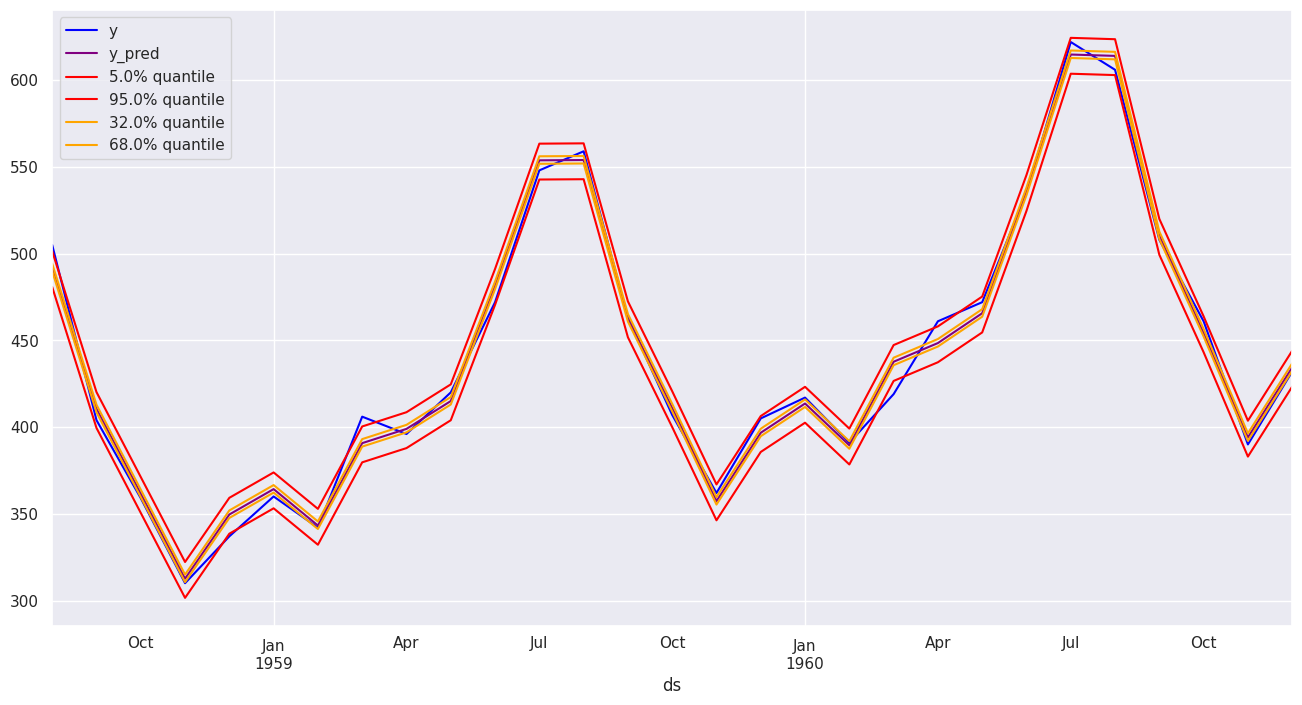

In [42]:
uncertainty_colors = ['blue', 'purple', 'red', 'red', 'orange', 'orange']
uncertainty_df[['y', 'y_pred', '5.0% quantile', '95.0% quantile', '32.0% quantile', '68.0% quantile']].plot(figsize=figsize, color=uncertainty_colors)

In [43]:
from crepes import ConformalPredictiveSystem
residuals_cal = y_cal - (y_pred_cal + cal_seasonal + cal_trend)
cps_norm = ConformalPredictiveSystem().fit(residuals_cal)
eval_metrics = cps_norm.evaluate(y_pred_test+test_seasonal+test_trend, y_test, metrics=["time_fit", "CRPS"])['CRPS']
print(f'The CRPS is {eval_metrics}')

The CRPS is 4.4282303320819185


/home/kevin/.conda/envs/sybil/lib/python3.9/site-packages/crepes/base.py:1053: UserWarning: the no. of calibration examples is too small for the following lower percentiles: 2.500000000000002; the corresponding values are set to y_min
  warnings.warn("the no. of calibration examples is " \
/home/kevin/.conda/envs/sybil/lib/python3.9/site-packages/crepes/base.py:1106: UserWarning: the no. of calibration examples is too small for the following higher percentiles: 97.5; the corresponding values are set to y_max
  warnings.warn("the no. of calibration examples is " \


In [44]:
uncertainty_df['y'].describe()

count     29.000000
mean     440.310345
std       79.514196
min      310.000000
25%      391.000000
50%      419.000000
75%      472.000000
max      622.000000
Name: y, dtype: float64

CRPS measures the difference between the predicted probability distribution and the actual observation. More specifically, it measures the scaled deviation between each predicted CPD and actual observation. The final CRPS is the average of the deviations of all observations. A smaller CRPS means the forecast is more accurate.

In this case, our actual target variable ranges from 310 to 622 with a mean of 440.310345 and a median of 419. A CRPS of 4.4282303320819185 means the predicted conformal predictive distribution is pretty close to the actual values given the scale of the data. 

Reference: https://crepes.readthedocs.io/en/latest/_modules/crepes/base.html#WrapRegressor.evaluate

**Final plot with train, calibration, and test set. Including the predicted values and 5-95% and 32-68% prediction intervals from the quantiles.**

In [45]:
df = pd.concat([train_df, cal_df, uncertainty_df]).reset_index()
df

,ds,y,y_pred,5.0% quantile,14.0% quantile,23.0% quantile,32.0% quantile,41.0% quantile,50.0% quantile,59.0% quantile,68.0% quantile,77.0% quantile,86.0% quantile,95.0% quantile
0,1949-01-31,112.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1949-02-28,118.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1949-03-31,132.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1949-04-30,129.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1949-05-31,121.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,1960-08-31,606.0,614.008212,602.941659,610.822210,611.435453,612.013191,612.475741,613.344873,614.078349,616.337457,617.075426,620.141442,623.623297
140,1960-09-30,508.0,510.401357,499.334804,507.215354,507.828598,508.406335,508.868886,509.738018,510.471493,512.730602,513.468571,516.534586,520.016441
141,1960-10-31,461.0,454.217738,443.151185,451.031735,451.644979,452.222716,452.685267,453.554399,454.287874,456.546983,457.284952,460.350967,463.832823
142,1960-11-30,390.0,394.053148,382.986594,390.867145,391.480388,392.058126,392.520677,393.389808,394.123284,396.382393,397.120362,400.186377,403.668232


In [46]:
uncertainty_df.reset_index(inplace=True)
uncertainty_df

,ds,y,y_pred,5.0% quantile,14.0% quantile,23.0% quantile,32.0% quantile,41.0% quantile,50.0% quantile,59.0% quantile,68.0% quantile,77.0% quantile,86.0% quantile,95.0% quantile
0,1958-08-31,505.0,491.863957,480.797404,488.677955,489.291198,489.868935,490.331486,491.200618,491.934094,494.193202,494.931171,497.997186,501.479042
1,1958-09-30,404.0,410.569162,399.502608,407.383159,407.996402,408.574140,409.036691,409.905822,410.639298,412.898407,413.636376,416.702391,420.184246
2,1958-10-31,359.0,361.584717,350.518164,358.398715,359.011958,359.589696,360.052246,360.921378,361.654854,363.913962,364.651931,367.717947,371.199802
3,1958-11-30,310.0,312.611600,301.545047,309.425597,310.038841,310.616578,311.079129,311.948261,312.681736,314.940845,315.678814,318.744829,322.226684
4,1958-12-31,337.0,349.601888,338.535335,346.415886,347.029129,347.606867,348.069417,348.938549,349.672025,351.931133,352.669102,355.735118,359.216973
5,1959-01-31,360.0,364.237937,353.171384,361.051934,361.665178,362.242915,362.705466,363.574598,364.308073,366.567182,367.305151,370.371166,373.853021
6,1959-02-28,342.0,343.238255,332.171702,340.052253,340.665496,341.243233,341.705784,342.574916,343.308392,345.567500,346.305469,349.371484,352.853340
7,1959-03-31,406.0,390.740917,379.674363,387.554914,388.168157,388.745895,389.208446,390.077577,390.811053,393.070162,393.808131,396.874146,400.356001
8,1959-04-30,396.0,398.955284,387.888731,395.769282,396.382525,396.960262,397.422813,398.291945,399.025421,401.284529,402.022498,405.088513,408.570369
9,1959-05-31,420.0,415.002028,403.935475,411.816026,412.429269,413.007007,413.469557,414.338689,415.072165,417.331273,418.069242,421.135258,424.617113


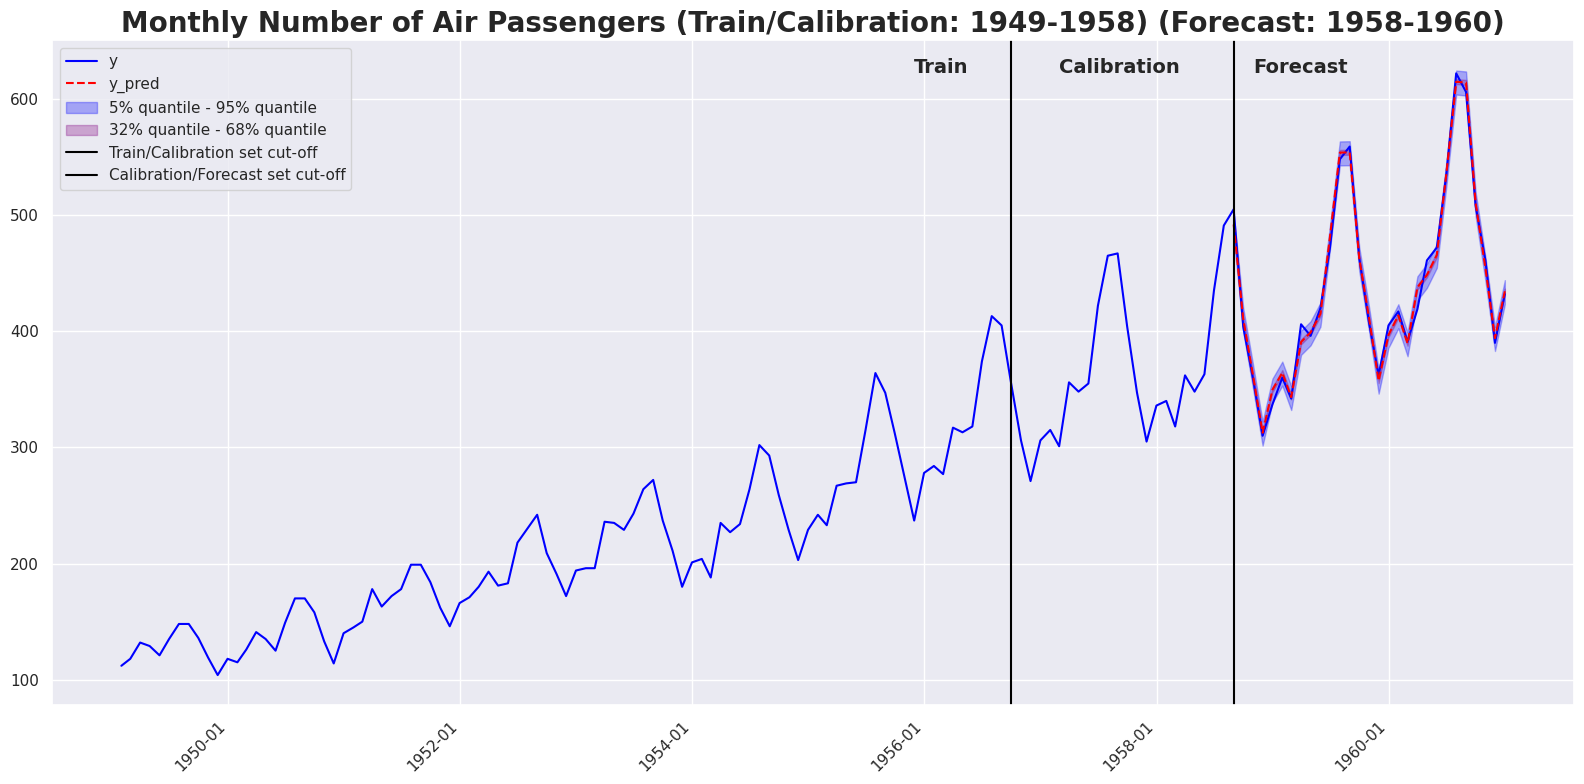

In [47]:
plt.figure(figsize=figsize)

plt.plot(df[time_col], df[target_col], color='blue', label='y')
plt.plot(uncertainty_df[time_col], uncertainty_df['y_pred'], color='red', linestyle='dashed', label='y_pred')
plt.fill_between(uncertainty_df[time_col], uncertainty_df['5.0% quantile'], uncertainty_df['95.0% quantile'], 
                 color='blue', alpha=0.3, label='5% quantile - 95% quantile')
plt.fill_between(uncertainty_df[time_col], uncertainty_df['32.0% quantile'], uncertainty_df['68.0% quantile'], 
                 color='purple', alpha=0.3, label='32% quantile - 68% quantile')
plt.axvline(x=df[time_col].iloc[len(train_df)], color='black', label='Train/Calibration set cut-off')
plt.axvline(x=df[time_col].iloc[len(train_df)+len(cal_df)], color='black', label='Calibration/Forecast set cut-off')

plt.text(df[time_col].iloc[len(train_df)-10], df[target_col].max(), 'Train', fontweight='bold', fontsize=14)
plt.text(df[time_col].iloc[len(train_df)+5], df[target_col].max(), 'Calibration', fontweight='bold', fontsize=14)
plt.text(df[time_col].iloc[len(train_df)+25], df[target_col].max(), 'Forecast', fontweight='bold', fontsize=14)

plt.title('Monthly Number of Air Passengers (Train/Calibration: 1949-1958) (Forecast: 1958-1960)', fontweight='bold', fontsize=20)
plt.legend()

ax = plt.gca()
# ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.setp(ax.get_xticklabels(), rotation=45, ha="right") 
plt.tight_layout()
plt.show()